*2yCR1

*2yCR2

*2yCR3

2yCR4*

*2yCR5

*2yHFD1

2yHFD3*

*2yHFD4

2yHFD5*

*2yHFD9

*9mCR1

9mCR4-

9mCR5

*9mCR6

*9mCR8

*9mHFD3

*9mHFD4

*9mHFD5

*9mHFD6

*9mHFD7

9mHFD8

In [1]:
import os
import sys
import itertools as itt

# File reading
from pathlib import Path
import czifile as czi
import tifffile as tiff
import aicsimageio as aicsi

# Image preprocessing
import cv2
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle
from skimage.morphology import remove_small_objects


# Calculations
from scipy import ndimage as ndi
import numpy as np

# Analysis
import astrobject as ao
import astro_graph as ag
import ccdb
import astromorpho as astro
import ucats

# Viewing
import napari
import matplotlib.pyplot as plt
%matplotlib inline

# Saving
import pickle

# Beauty
from tqdm.auto import tqdm

# Utils
from importlib import reload

Can't load imreg package, affine and homography registrations won't work


/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(
2022-12-13 16:22:55.119237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/levtg/astro-morpho/venv/lib/python3.10/site-packages/cv2/../../lib64:/home/levtg/v3d_external/v3d_main/common_lib/lib/
2022-12-13 16:22:55.119259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dler

In [2]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['image.cmap'] = 'gray'

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["black", "red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

# Параметры для запуска

In [4]:
if os.path.exists('/home/levtg/astro-morpho'):
#     data_dir = '/home/levtg/astro-morpho/data/human_glauk/'
    data_dir = '/home/levtg/astro-morpho/data/aging_diet'

else:
    print("Dont know where to look for the data")

output_dir = '/home/levtg/astro-morpho/data/aging_diet/output/'

filename = '9mCR6.tif'

use_clahe = True
sigmas = 2**np.arange(-1, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

USE_NAPARI = False


# Set false to start from console
HANDY = True

# Set true to save output
OUT = True
LOAD = False

# Считывание изображения

In [523]:
if HANDY:
    VERBOSE = True

In [524]:
basename = os.path.basename(filename)[:-4]

In [525]:
datapath = Path(data_dir).joinpath(basename + '.tif')
datapath_czi = Path('/home/levtg/astro-morpho/data/aging_diet/czi/' + basename + '.czi')
datapath, datapath_czi

(PosixPath('/home/levtg/astro-morpho/data/aging_diet/9mCR6.tif'),
 PosixPath('/home/levtg/astro-morpho/data/aging_diet/czi/9mCR6.czi'))

In [526]:
# tifname = Path(str(datapath)[:-3] + 'tif')

# if tifname.exists():
#     stack = tiff.imread(tifname)
# else:
#     raise Exception('ALARM!!!')
# # else:
# #     czi.czi2tif(datapath, tiffile=tifname)
# #     stack = tiff.imread(tifname)[2]
# stack.shape

In [527]:
img = aicsi.AICSImage(datapath_czi)
ratio = (img.physical_pixel_sizes.X, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.Z)
ratio

(0.4970000000000001, 0.4970000000000001, 1.0)

In [528]:
stack = tiff.imread(datapath)
if len(stack.shape) == 4:
    stack = stack[2]

In [529]:
stack.shape

(60, 512, 512)

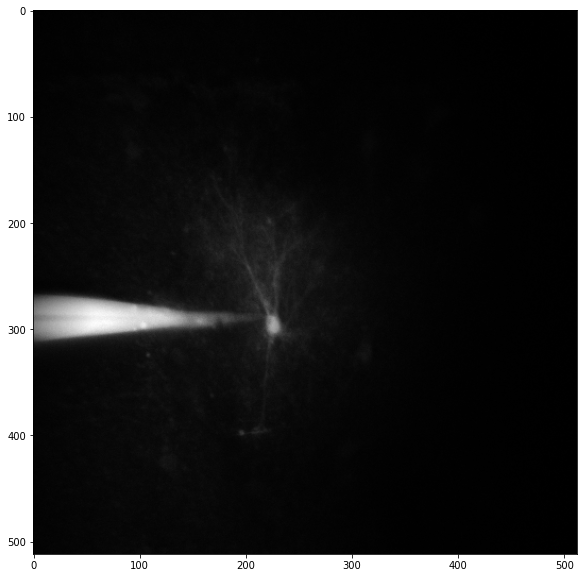

In [530]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(stack, ndisplay=3)
    else:
        imgplot = plt.imshow(np.sum(stack, axis=0))
        plt.show()

# Удаление пипетки

In [531]:
import pipette_segmentation as ps

In [486]:
image = stack

In [487]:
simple_mask = ps.make_simple_mask(image)
sato_mask = ps.make_sato_mask(image)
masks3 = ps.combine_masks(image, simple_mask, sato_mask)

vx = masks3.sum(axis=(1,2))
vx_sato = ps.st_roll(sato_mask).sum(axis=(1,2))

try:
    kink = ps.find_kink(vx)
except :
    #print(E)
    kink = len(vx)

masks3a = masks3.copy()
masks3a[kink:]=0
masks3a = ucats.masks.largest_region(masks3a)

  0%|          | 0/5 [00:00<?, ?it/s]

thresholds 0.060485351515210665 0.08833140566482922 0.17666281132965844
98


In [488]:
use_kink = False

In [489]:
masks3_final = masks3a if use_kink else masks3
masks3_final = np.moveaxis(masks3_final,0,2)

show_stack = (image*(~(ndi.binary_dilation(masks3_final,iterations=3)))).astype(np.float64)

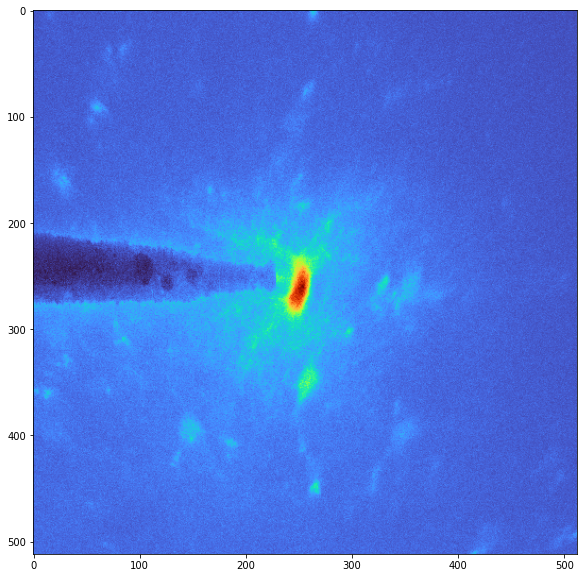

In [490]:
if VERBOSE:
    if USE_NAPARI:
        napari.view_image(show_stack, ndisplay=3)
    else:
        imgplot = plt.imshow(np.sum(show_stack, axis=0), cmap='turbo')
        plt.show()

# Предобработка изображения

## Фильтрация изображения

In [491]:
def largest_region(mask):
    labels, nlab = ndi.label(mask)
    if nlab > 0:
        objs = ndi.find_objects(labels)
        sizes = [np.sum(labels[o]==k+1) for k,o in enumerate(objs)]
        k = np.argmax(sizes)
        return labels==k+1
    else:
        return mask

In [449]:
def filter_image(image, filter_func):
    threshold = filter_func(image)
    #img_filt = np.where(image > threshold, image, 0)
    pre_mask = ndi.binary_closing(image >= threshold)
    pre_mask = remove_small_objects(pre_mask, 5, connectivity=3)
    binary_clean = largest_region(pre_mask)
    return np.where(binary_clean, image, 0)

In [450]:
img = show_stack

In [451]:
clean_img = filter_image(img, threshold_li)

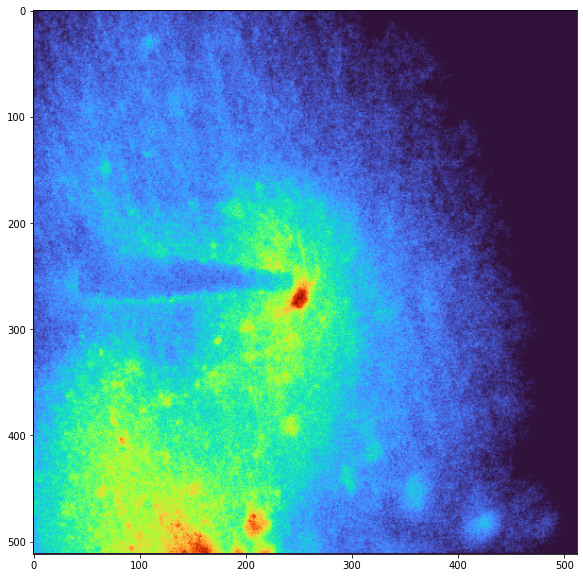

In [452]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(clean_img, opacity=0.5) 
#         w.add_image(clean_img, blending='additive')
    else:
        show_image = np.sum(clean_img, axis=0)
        imgplot = plt.imshow(show_image, cmap='turbo')
        plt.show()

## Очистка изображения

In [453]:
# sigma = 6

In [454]:
# def get_blobs(image, sigma):
#     frangi, blobness = astro.morpho.frangi(image, sigma, beta=0.5, return_blobness=True)
#     blobness2 = astro.enh.percentile_rescale(ndi.gaussian_filter(blobness, sigma), 0.1, 99.99)**2
#     frangi_weights = astro.enh.percentile_rescale(frangi, 0.1, 99.9)
#     mx = ucats.masks.threshold_object_size((frangi_weights > 0.5)*(blobness2 < 0.1), 27)
#     saved_blobs = ucats.masks.select_overlapping(blobness2 > 0.1, ndi.binary_dilation(mx))
#     return saved_blobs

In [455]:
# sigmas_clear = np.linspace(4, 10, 13)

In [456]:
# sigmas_clear

In [457]:
# w = napari.view_image(clean_img, ndisplay=3, visible=True, colormap='magenta')

# for sigma in tqdm(sigmas_clear):
#     blobs = get_blobs(clean_img, (sigma/2, sigma, sigma))
#     w.add_image(blobs, colormap='cyan',blending='additive',visible=True)    


# Сегментация. Построение графа

In [458]:
obj = ao.AstrObject(clean_img, ratio=ratio)
print('Center')
obj.center_detection()
obj.center

Center


(41, 401, 208)

In [459]:
# obj.center = (44, 231, 230) # 2yCR1
# obj.center = (27, 271, 235) # 2yCR3
# obj.center = (32, 257, 252) # 2yCR4
# obj.center = (50, 258, 235) # 2yHFD4

# obj.center = (36, 276, 225) # 2yHFD9
# obj.center = (24, 297, 226) # 9mCR6
# obj.center = (36, 266, 259) # 9mCR8
# obj.center = (34, 300, 234) # 9mHFD3
# obj.center = (35, 271, 251) # 9mHFD4
# obj.center = (39, 283, 271) # 9mHFD5
# obj.center = (33, 263, 257) # 9mHFD6
# obj.center = (35, 271, 252) # 9mHFD7
# obj.center = (37, 288, 252) # 9mHFD8


centers = {
    '2yCR1': (44, 231, 230),
    '2yCR3': (27, 271, 235),
    '2yCR4': (32, 257, 252),
    '2yHFD4': (50, 258, 235),
    '2yHFD9': (36, 276, 225),
    '9mCR6': (24, 297, 226),
    '9mCR8': (36, 266, 259),
    '9mHFD3': (34, 300, 234),
    '9mHFD4': (35, 271, 251),
    '9mHFD5': (39, 283, 271),
    '9mHFD6': (33, 263, 257),
    '9mHFD7': (35, 271, 252),
    '9mHFD8': (37, 288, 252)
}

if basename in centers.keys():
    obj.center = centers[basename]


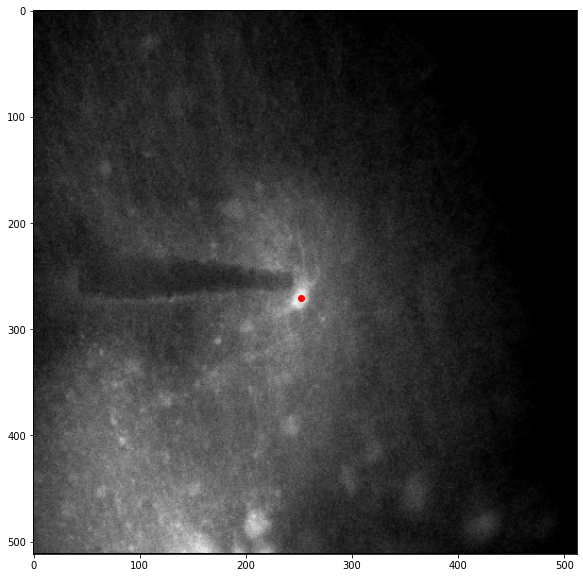

In [460]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_points(obj.center)
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        plt.scatter(*obj.center[:0:-1], c='r')
        plt.show()

In [461]:
print('Soma Mask')
%time obj.soma_segmentation(return_shell=True)

Soma Mask
Mask Expanding
Soma Shell
CPU times: user 37.5 s, sys: 145 ms, total: 37.7 s
Wall time: 37.7 s


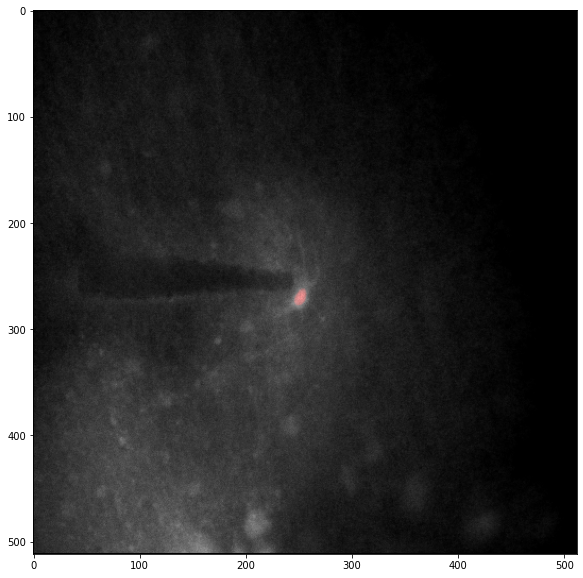

In [462]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_image(obj.soma_mask, blending='additive', colormap='red')
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        plt.imshow(np.sum(obj.soma_mask, axis=0), cmap=cmap1, alpha=0.4)
        plt.show()

In [463]:
print('Branch Segmentation')
%time obj.branch_segmentation((1,), sigmas=sigmas)

Branch Segmentation
Vectors...


Calculating:   0%|          | 0/8 [00:00<?, ?it/s]

Masks and sigmas cleaning...
Merging...
CPU times: user 3min 51s, sys: 29.1 s, total: 4min 20s
Wall time: 1min 19s


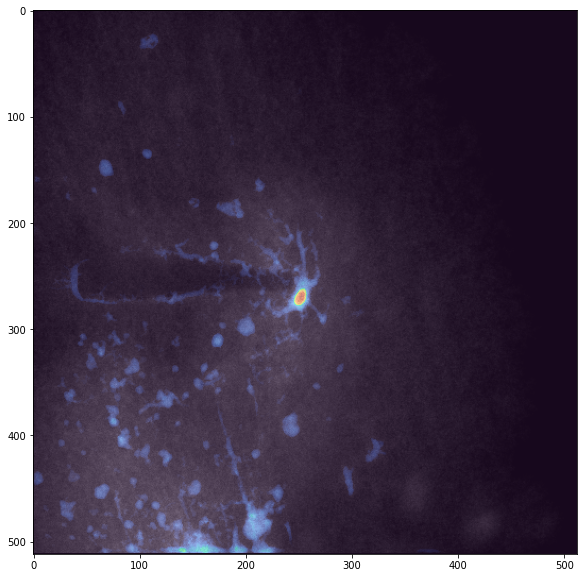

In [464]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
        w.add_image(obj.sigma_mask, blending='additive', colormap='turbo')
        for sigma in obj.sigmas:
            w.add_image(obj.masks_exclusive[sigma], blending='additive', name='sigma {:.2f}'.format(sigma))
    else:
        show_image = np.sum(obj.image, axis=0)
        imgplot = plt.imshow(show_image)
        mask_image = obj.sigma_mask.copy()
        mask_image[obj.soma_mask] = 50
        
        plt.imshow(np.sum(mask_image, axis=0), cmap='turbo', alpha=0.5)
        plt.show()

In [521]:
print('Full Graph')
%time obj.full_graph_construction(alpha, beta, preventing_jumps=False)

Full Graph


Edge calculation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7fcf021bf1c0>
Traceback (most recent call last):
  File "/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [466]:
def save_points(viewer, path=None):
    "Convert layers of a napari Viewer to a pickleable format and save to a file if path is given"
    layer_data = np.array([tuple(map(int, p)) for p in w.layers[1].data])
    if path is not None:
        #_ = v.screenshot(path.stem + '-snapshot.png')
        np.save(path, arr=layer_data)
    return layer_data

def load_my_rois(path, viewer=None):
    "load pickled layers data and add to a napari Viewer if given"
    if isinstance(path, (Path, str)):
        print('loading from file')
        layer_data = pickle.load(open(path, 'rb'))
    else:
        layer_data = path
    layers = [napari.layers.Layer.create(ld[0] if np.size(ld[0]) else None, 
                                         ld[1], ld[2]) for ld in layer_data]
    if viewer is not None:
        for ll in layers:
            viewer.add_layer(ll)
    return layers

def initiate_point_picker(image, soma_shell=None):
    w = napari.Viewer()
    w.add_image(image, blending='additive', name='cell', opacity=0.75, colormap='gist_earth')
    if soma_shell is not None:
        w.add_image(soma_shell, blending='additive', name='shell', colormap='red')
    tips_layer = w.add_points(edge_color='red', face_color='red', symbol='+', size=1, name='tips', ndim=3)
    sources_layer = w.add_points(edge_color='green', face_color='green', symbol='+', size=1, name='sources', ndim=3)
    return w

In [467]:
if LOAD:
    points = np.load(numpy_name)
    tips = [tuple(map(int, p)) for p in points['tips']]
    sources = [tuple(map(int, p)) for p in points['sources']]

In [468]:
# point_picker = initiate_point_picker(obj.image, obj.soma_shell_mask)
# point_picker.add_image(obj.sigma_mask)

In [469]:
# tips = [tuple(map(int, p)) for p in point_picker.layers[2].data]
# sources = [tuple(map(int, p)) for p in point_picker.layers[3].data]

In [470]:
# print('Targets Graph')
# %time obj.tips_graph_creation(tips=tips, sources=sources)
# obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=point_picker)

In [471]:
# obj.full_graph.nodes

In [472]:
print('Graph')
%time obj.astro_graph_creation(loneliness=5)

Graph
scaling sequential paths...


  0%|          | 0/8 [00:00<?, ?it/s]

5.656854249492381
4.0
2.8284271247461903
2.0
1.4142135623730951
1.0
0.7071067811865476
0.5
compose path segments...


  0%|          | 0/280 [00:00<?, ?it/s]

No cycles!
CPU times: user 5.58 s, sys: 18.3 ms, total: 5.6 s
Wall time: 5.6 s


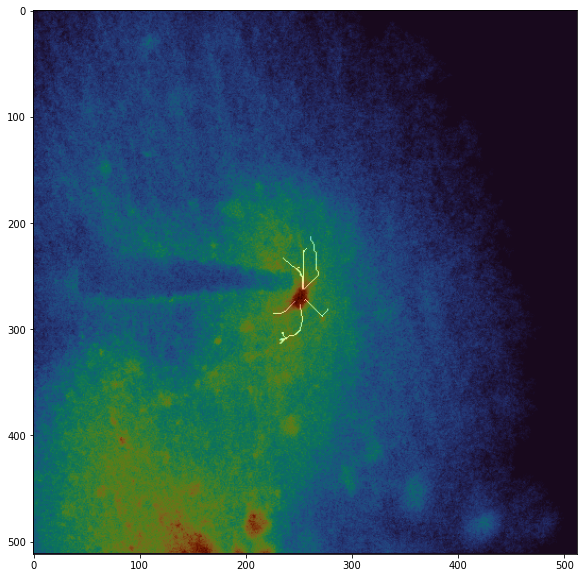

In [473]:
if VERBOSE:
    if USE_NAPARI:
        w = napari.view_image(obj.image, ndisplay=3, opacity=0.5)
        obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)
        for sigma in obj.sigmas:
            w.add_image(obj.masks[sigma], blending='additive', name='sigma {:.2f}'.format(sigma), visible=False)
        w.add_image(obj.sigma_mask, blending='additive', colormap='turbo', visible=False)
    else:
        test_image = np.zeros(img.shape)
        points = np.array(list(obj.graph.nodes))
        test_image[points[:,0], points[:,1], points[:,2]] = 1
        
        sum_img = np.sum(test_image, axis=0)
        sum_img[sum_img.astype(bool)] = 1
        
        show_image = np.sum(obj.image, axis=0)
        plt.imshow(show_image, cmap='turbo')
        plt.imshow(sum_img, alpha=0.5)
#         plt.savefig(filename[:-3])

In [474]:
_ = -1

# Постобработка

## Обрезка ветвей

In [423]:
pruning = napari.view_image(obj.image, ndisplay=3, opacity=0.5)
obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=pruning)
cut_layer = pruning.add_points(edge_color='red', face_color='red', symbol='+', size=1, name='cuts', ndim=3)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [251]:
points2del = list(map(lambda x: tuple(map(lambda y: int(np.round(y)), x)), cut_layer.data))
obj.graph.cut_branches(points2del)

In [316]:
w = napari.view_image(obj.image, ndisplay=3, opacity=0.5)
obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(34.5, 255.5, 255.5), zoom=3.0244140625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 70.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(35, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7fce316eaf80>, <Image layer 'Image [1]' at 0x7fce19e63760>, <Image layer 'Image [2]' at 0x7fce7c0847f0>, <Image layer 'Image [3]' at 0x7fce7c006260>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: '

## Удаление параллельных участков

In [176]:
import networkx as nx
import astro_graph as ag

In [173]:
def draw_nodes(pos, nodelist):
    return np.asarray([pos[n] for n in nodelist])
def choose_main(chosen_keys, values, mass_func=len):
    '''values - dict with keys contain chosen_keys and which values we should compare'''
    max_mass = 0
    main_key = None
    main_value = None
    for key in chosen_keys:
        value = values[key]
        if main_key is None or main_value is None:
            main_key, main_value = key, value
        value_mass = mass_func(value)
        if value_mass > max_mass:
            max_mass = value_mass
            main_key = key
            main_value = values[main_key]
    return main_key, main_value

In [180]:
def remove_parallels(self, min_dist=4):
    bunches = self.get_bunches(min_dist)
    branches = self.branches
    pos = {node: node for node in self.nodes}

    for bunch in bunches:
        main_branch_root, main_branch = choose_main(bunch, branches, lambda x: len(x.nodes()))
        main_branch_lines = ag.AstroGraph.make_lines(main_branch, main_branch_root)
        if len(main_branch.tips) < 1:
            continue
        main_branch_line_tip, (main_branch_line, main_branch_line_mass) = choose_main(main_branch.tips, main_branch_lines)
        main_branch_points = draw_nodes(pos, main_branch_line)

        # mr, mb = choose_main(bunch, branches, lambda x: len(x.nodes()))
        # main_branch = Branch(mb, mr)

        for branch_root in tqdm(bunch):
            # Can be switch off if need to remove parallels from branch itself (NOT WORKING FOR NOW)
            if branch_root == main_branch_root:
                continue
            branch = branches[branch_root]
            nx.set_node_attributes(self.graph, {p: main_branch_root for p in branch.nodes()}, name='root')


            for line, line_mass in ag.AstroGraph.make_lines(branch, branch_root).values():
                points = draw_nodes(pos, line)

        #         branch_paths = list(branch.graph_to_paths().values())
        #         for path in branch_paths[0]:
        #             path = [branch_root] + path
        #             points = draw_nodes(pos, path)

                count = min(len(points), len(main_branch_points))
                dists = np.linalg.norm(points[:count] - main_branch_points[:count], axis=-1)
                clear_line(self, points[:count], main_branch_points[:count], dists, min_dist)
    self.check_roots()


def clear_line(self, points, main_points, dists, min_dist=4):
    # REMOVED = False
    for p, mbp, d in zip(points, main_points, dists):
        point = p
        mb_point = mbp

        if tuple(p) not in self.graph or tuple(p) == tuple(mbp):
            continue
        elif self.graph.nodes[tuple(p)]['sigma_mask'] == self.graph.nodes[tuple(mbp)]['sigma_mask'] \
            or d <= min_dist:
#                 min(data.graph.nodes[tuple(mbp)]['sigma_opt'], data.graph.nodes[tuple(p)]['sigma_opt']):
            self.graph.remove_node(tuple(p))
#             print('DELETED: {}'.format(point))    
        else:
            break

    else:
        point = mb_point

    print('start_point: {}, end_point: {}'.format(mb_point, point))
    connect_points(self, mb_point, point)


def connect_points(self, start_point, end_point):
    cur_p = start_point
    prev_p = start_point
    end_p = end_point
    azi = np.array([*np.sign(end_p - cur_p)])

    root = self.nodes[tuple(start_point)]['root']

    while tuple(cur_p) != tuple(end_p):
        cur_p = np.clip(cur_p + azi, np.min([start_point, end_point], axis=0), np.max([start_point, end_point], axis=0))
        print('prev_p: {}, cur_p: {}'.format(prev_p, cur_p))
        if self.graph.has_edge(tuple(prev_p), tuple(cur_p)) or self.graph.has_edge(tuple(cur_p), tuple(prev_p)):
            prev_p = cur_p
            continue
        self.graph.add_node(tuple(cur_p), root=root) #Add another parameters        
        self.graph.add_edge(tuple(prev_p), tuple(cur_p))
        prev_p = cur_p

In [52]:
# print('Graph')
# %time obj.astro_graph_creation(loneliness=5)

Graph
scaling sequential paths...


  0%|          | 0/8 [00:00<?, ?it/s]

5.656854249492381



KeyboardInterrupt



In [253]:
remove_parallels(loaded.graph, min_dist=3)
# roots = obj.graph.roots
# for root in roots:
#     print(list(obj.graph.successors(root)))

NetworkXNoPath: No path between (36, 263, 253) and (56, 238, 232).

In [125]:
_ = -1

In [220]:
if HANDY:
    # min_dist=4
    start_points = np.array([[24, 278, 219], [25, 272, 217], [24, 291, 190]])
    end_points = np.array([[25, 278, 228], [21, 273, 220], [24, 291, 190]])

    # min_dist=3
    # start_points = np.array([[21, 287, 224], [24, 296, 236]])
    # end_points = np.array([[21, 289, 218], [21, 290, 218], [24, 304, 236]])

In [254]:
obj.graph.check_for_cycles(verbose=True)

No cycles!


In [1]:
if HANDY:
    for node in start_points:
        print(obj.graph.graph.in_edges(tuple(node)))
        print(obj.graph.graph.out_edges(tuple(node)))

NameError: name 'HANDY' is not defined

In [223]:
# for node in end_points:
#     print(obj.graph.graph.in_edges(tuple(node)))
#     print(obj.graph.graph.out_edges(tuple(node)))

[((25, 279, 228), (25, 278, 228))]
[((25, 278, 228), (26, 277, 229)), ((25, 278, 228), (25, 277, 228))]
[((21, 274, 220), (21, 273, 220))]
[((21, 273, 220), (21, 272, 220))]
[((24, 290, 191), (24, 291, 190))]
[((24, 291, 190), (24, 292, 190))]


In [59]:
if HANDY:
    import itertools as itt

    def draw_nodes(pos, nodelist):
        return np.asarray([pos[n] for n in nodelist])

    bunches = obj.graph.get_bunches(min_dist=3.5)
    branches = {}
    for root in obj.graph.roots:
        branches[root] = ag.AstroGraph(obj.graph.filter_graph(lambda node: node['root'] == root))
    data = obj

    w = napari.view_image(data.image, opacity=0.5)
    pos = {node: node for node in data.graph.nodes}
    colors = ['blue', 'red', 'yellow', 'cyan', 'green', 'magenta', 'bop orange']


    for bunch, color in zip(bunches, itt.cycle(colors)):
        img = np.zeros(data.image.shape)
        for root in bunch:
            points = draw_nodes(pos, branches[root].nodes())
            img[points[:, 0], points[:, 1], points[:, 2]] = 1
        w.add_image(img, colormap=color, blending='additive')

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [48]:
def check_roots(self):
    for root in self.roots:
        print(root)
        print(root in self.graph)
        try:
            nodes = self.get_sector(root)
        except:
            continue
        for node in nodes:
            nx.set_node_attributes(self.graph, root, 'root')

In [126]:
w = napari.view_image(obj.image, opacity=0.5, ndisplay=3)
obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(34.5, 255.5, 255.5), zoom=3.0244140625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 70.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(35, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7fce6530b1f0>, <Image layer 'Image [1]' at 0x7fce5d6eae90>, <Image layer 'Image [2]' at 0x7fce3eaa84f0>, <Image layer 'Image [3]' at 0x7fce60599900>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: '

In [309]:
# w.add_image(obj.sigma_mask)

<Image layer 'Image [4]' at 0x7f397225c190>

In [155]:
# w.add_points(start_points, edge_color='transparent', face_color='green', size=2)
# w.add_points(end_points, edge_color='transparent', face_color='red', size=2)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'end_points' at 0x7f3ba685a140>

In [52]:
import astro_graph as ag

In [60]:
# pos_ = {node: node for node in obj.graph.nodes}

# img = np.zeros(obj.image.shape)

# points = ag.draw_nodes(pos_, obj.graph.nodes())

# img[points[:, 0], points[:, 1], points[:, 2]] = 1
# w.add_image(img, colormap='gray', blending='additive', name='main branch')

<Image layer 'main branch' at 0x7fb7775df400>

In [197]:
# w = napari.view_image(obj.image, ndisplay=3, opacity=0.5)
# obj.graph.view_graph_as_colored_image(obj.image.shape, viewer=w)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 360.1223979100819, 225.3027158553845), zoom=37.24153150607163, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(34.0, 371.5880968311453, 204.94909534753086), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 60.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(34, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f3ba69331f0>, <Image layer 'Image [1]' at 0x7f3b69b50d00>, <Image layer 'Image [2]' at 0x7f3b65d324a0>, <Image layer 'Image [3]' at 0x7f3b65d23d00>, <Image layer 'Image [4]' at 0x7f3ba5765780>, <Image layer 'Image [5]' at 0x7f3ba72cfe50>, <Image layer 'Image [6]' at 0x7f3ba7283eb0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, positi

# Сохранение

In [475]:
name = str(filename).split('.')[0]
pickle_name = os.path.join(output_dir, name + '_ratio.pickle')
swc_name = os.path.join(output_dir, name + '_ratio' + '.swc')

# numpy_name = os.path.join(output_dir, name + '.npz')

# if OUT:
%time pickle.dump(obj, open(pickle_name, 'wb'))
obj.swc_save(7, swc_name, ratio=ratio)
#     np.savez(numpy_name, tips=tips, sources=sources)

CPU times: user 13.2 s, sys: 1.87 s, total: 15.1 s
Wall time: 20.8 s


  0%|          | 0/6 [00:00<?, ?it/s]

In [426]:
_ = -1

# Обработка результатов

In [25]:
# w = napari.view_image(show_image)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/levtg/astro-morpho/venv/lib64/python3.10/site-pac

In [24]:
from skimage.measure import profile_line

In [189]:
# fig, axs = plt.subplots((1,3))
# for i, ax in enumerate(axs.ravel()):
#     ax.plot(profile_line(show_image, *w.layers[1].data[i]))

SyntaxError: incomplete input (3869124240.py, line 2)

## Подсчёт длин отростков

### От корня к концу

In [49]:
# import pandas as pd
# import glob
# import networkx as nx

In [10]:
# def make_lines(branch, root):
#     lines = {}
#     for tip in branch.get_tips():
#         lines[tip] = nx.shortest_path(branch.graph, root, tip), nx.shortest_path_length(branch.graph, root, tip)
#     return lines

In [9]:
# def get_branches(self):
#     branches = {}
#     for root in self.get_roots():
#         branches[root] = ag.AstroGraph(self.filter_graph(lambda node: node['root'] == root))
#     return branches

In [52]:
# def get_length(path):
#     length = 0
#     for i, p in enumerate(path[:-1]):
#         length += np.linalg.norm(np.array(p)-np.array(path[i+1]))
#     return length
        

In [ ]:
# data_dir = '/home/levtg/astro-morpho/data/human_glauk/output/'

In [54]:
# data_ = pd.DataFrame(columns=['cell', 'count', 'lengths'])

In [60]:
# for i, path in enumerate(tqdm(glob.glob(data_dir + "*.pickle"))):
#     name = path.split('/')[-1].split('.')[0]
    
#     cell = pickle.load(open(path, 'rb'))
    
#     n_tips = len(cell.graph.get_tips())
    
#     processors = {}
#     for root, branch in get_branches(cell.graph).items():
#         processors.update(make_lines(branch, root))
#     lengths = [get_length(p) for p, l in list(processors.values())]
    
# #     lengths = [l for p, l in list(processors.values())]
    
#     data_.loc[i] = [name, n_tips, lengths]

  0%|          | 0/9 [00:00<?, ?it/s]

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


KeyboardInterrupt: 

In [61]:
# data_

,cell,count,lengths
0,T5_,42,"[92.31492141375966, 39.95205381986931, 146.773..."
1,T6_1,31,"[(48, 70.48236554280246), (48, 70.482365542802..."
2,T1,5,"[(41, 50.26649127671307), (23, 34.684104627438..."
3,T3_2,9,"[(62, 80.407897942585), (45, 63.31152162540768..."
4,Т9,1,"[(27, 39.291070824165914)]"
5,T7_1,19,"[(20, 28.341687834789592), (24, 32.72719310349..."
6,T1_2,6,"[(22, 34.41615543500708), (15, 20.095647359318..."
7,T3,2,"[(20, 26.752501608810682), (33, 41.75590139716..."
8,T4_,3,"[(111, 130.33270138450848), (57, 75.7544434814..."


In [62]:
# data_.set_index('cell').sort_index()

,count,lengths
cell,,
T1,5,"[(41, 50.26649127671307), (23, 34.684104627438..."
T1_2,6,"[(22, 34.41615543500708), (15, 20.095647359318..."
T3,2,"[(20, 26.752501608810682), (33, 41.75590139716..."
T3_2,9,"[(62, 80.407897942585), (45, 63.31152162540768..."
T4_,3,"[(111, 130.33270138450848), (57, 75.7544434814..."
T5_,42,"[92.31492141375966, 39.95205381986931, 146.773..."
T6_1,31,"[(48, 70.48236554280246), (48, 70.482365542802..."
T7_1,19,"[(20, 28.341687834789592), (24, 32.72719310349..."
Т9,1,"[(27, 39.291070824165914)]"


In [63]:
# data_.to_csv('/home/levtg/astro-morpho/data/human_glauk/output/processors_lengths.csv')

# Просмтор результатов

In [17]:
# data_dir = '/home/levtg/astro-morpho/data/human_glauk/output/'
# filename = 'T5_.tif.pickle'

In [4]:
if os.path.exists('/home/levtg/astro-morpho'):
#     data_dir = '/home/levtg/astro-morpho/data/human_glauk/'
    data_dir = '/home/levtg/astro-morpho/data/aging_diet/output'

else:
    print("Dont know where to look for the data")

output_dir = '/home/levtg/astro-morpho/data/aging_diet/output/'

filename = '9mHFD7.tif'

use_clahe = True
sigmas = 2**np.arange(-1, 3, 0.5)
alpha = 0.5 # relative weight of coside distance between Hessian vector and linkage vector
beta = 0.0  # weight of Euclidean distance between the nodes 
offset=1

VERBOSE = True

USE_NAPARI = False


# Set false to start from console
HANDY = True

# Set true to save output
OUT = True
LOAD = False

In [5]:
basename = os.path.basename(filename)[:-4]

In [6]:
datapath = Path(data_dir).joinpath(basename + '_ratio.pickle')
# # datapath = Path(data_dir).joinpath(filename)
datapath

PosixPath('/home/levtg/astro-morpho/data/aging_diet/output/9mHFD7_ratio.pickle')

In [7]:
loaded = pickle.load(open(datapath, 'rb'))
# # loaded = obj

Граф

In [10]:
w = napari.view_image(loaded.image, ndisplay=3, opacity=0.5)
loaded.graph.view_graph_as_colored_image(loaded.image.shape, viewer=w)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(34.5, 255.5, 255.5), zoom=3.0244140625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=3, last_used=0, range=((0.0, 70.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(35, 256, 256), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7fe86955cd90>, <Image layer 'Image [1]' at 0x7fe86955c730>, <Image layer 'Image [2]' at 0x7fe86934f970>, <Image layer 'Image [3]' at 0x7fe86902aaa0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: '

In [432]:
_ = -1

In [369]:
pruning = napari.view_image(loaded.image, ndisplay=3, opacity=0.5)
loaded.graph.view_graph_as_colored_image(loaded.image.shape, viewer=pruning)
cut_layer = pruning.add_points(edge_color='red', face_color='red', symbol='+', size=1, name='cuts', ndim=3)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [372]:
points2del = list(map(lambda x: tuple(map(lambda y: int(np.round(y)), x)), cut_layer.data))
loaded.graph.cut_branches(points2del)

In [374]:
name = str(filename).split('.')[0]
pickle_name = os.path.join(output_dir, name + '_ratio.pickle')
swc_name = os.path.join(output_dir, name + '_ratio' + '.swc')

# numpy_name = os.path.join(output_dir, name + '.npz')

# if OUT:
%time pickle.dump(loaded, open(pickle_name, 'wb'))
loaded.swc_save(7, swc_name, ratio=loaded.ratio)
#     np.savez(numpy_name, tips=tips, sources=sources)

CPU times: user 31.7 s, sys: 3.39 s, total: 35.1 s
Wall time: 37.5 s


  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
loaded.graph.remove_parallels()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Клетка

In [38]:
# w = napari.view_image(loaded.image, ndisplay=3)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [63]:
# sources = w.layers[1].data
# tips = w.layers[2].data

In [ ]:
# def get_shell_mask(mask, do_skeletonize=False, as_points=False):
#     out = ndi.binary_erosion(mask)^mask
#     if do_skeletonize:
#         out = skeletonize(out)
#     if as_points:
#         out = astro.morpho.mask2points(out)
#     return out 

In [ ]:
# domain_mask3d = ndi.binary_fill_holes(loaded.image > 0)
# domain_shell_mask = get_shell_mask(domain_mask3d)

In [ ]:
# def planewise_fill_holes(mask):
#     for k,plane in enumerate(mask):
#         mask[k] = ndi.binary_fill_holes(plane)
#     return mask

    
# domain_mask3d = planewise_fill_holes(domain_mask3d)

# domain_mask3d = np.moveaxis(domain_mask3d, 1, 0)   
# domain_mask3d = planewise_fill_holes(domain_mask3d)
# domain_mask3d = np.moveaxis(domain_mask3d, 0, 1)


# domain_mask3d = np.moveaxis(domain_mask3d, 2, 0)
# domain_mask3d = planewise_fill_holes(domain_mask3d)
# domain_mask3d = np.moveaxis(domain_mask3d, 0, 2)

In [ ]:
# domain_outer_shell_mask = get_shell_mask(domain_mask3d) & domain_shell_mask

In [ ]:
# w.add_image(domain_shell_mask, colormap='green', blending='additive')
# w.add_image(domain_outer_shell_mask, colormap='red', blending='additive')

Маски

In [71]:
# i = -1

In [72]:
# w = napari.view_image(loaded.image[:i], ndisplay=3, opacity=0.5)
# w.add_image(loaded.sigma_mask[:i], blending='additive', colormap='turbo', visible=False)
# for sigma in loaded.sigmas:
#     w.add_image(loaded.masks[sigma][:i], blending='additive', name='sigma {:.2f}'.format(sigma), visible=False)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [46]:
# points = [tuple(map(int, p)) for p in w.layers[-1].data]
# points

[(46, 317, 193), (46, 290, 176)]

In [139]:
# points[0] = (45, 320, 193)

In [123]:
# from skimage.morphology import flood, flood_fill, dilation, ball

In [140]:
# image = loaded.image.copy()

In [116]:
# smooth_stack = ndi.gaussian_filter(loaded.image, 2)
# w.add_image(smooth_stack)

<Image layer 'smooth_stack' at 0x7f38e9ae0910>

In [141]:
# tolerance = (smooth_stack.max() - smooth_stack[loaded.image>0].min())/5
# print(tolerance)
# for point in points:
#     blob_mask = flood(smooth_stack, point, tolerance=tolerance)
#     blob_mask = dilation(blob_mask, ball(4))
#     arr = flood_fill(blob_mask, (0,0,0), True)
#     blob_mask += ~arr
#     image[blob_mask] = 0
#     w.add_image(blob_mask, blending='additive')

13065.225040463585


In [142]:
# w.add_image(image)

<Image layer 'image [2]' at 0x7f390ff03250>

In [143]:
# _ = -1

Векторное поле

In [519]:
# mask_sum = np.zeros(loaded.image.shape, bool)
# emasks = {}
# for k in range(len(loaded.sigmas)-1,-1,-1):
#     sigma = loaded.sigmas[k]
#     mask = loaded.masks[sigma]
#     if k < len(loaded.sigmas)-1:
#         mask = mask & (mask ^ mask_sum)
#     mask_sum += mask.astype(bool)
#     emasks[sigma] = mask

KeyboardInterrupt: 

In [446]:
# w = napari.view_image(loaded.image, opacity=0.5, ndisplay=3)
# #     colors = ['red', 'green', 'magenta', 'cyan', 'blue']

# for sigma in list(loaded.masks.keys())[:-1]:
#     vectors = loaded.vectors[emasks[sigma]]
# #     print('Vectors shape:', vectors.shape)
#     nd, nr, nc = loaded.image.shape
#     #indexgrid = np.meshgrid(np.arange(nd), np.arange(nr), np.arange(nc), indexing='ij')
#     indexgrid = np.mgrid[:nd, :nr, :nc]
# #     print('Indexgrid shape:', indexgrid[0].shape)

#     z, y, x = [np.ravel(a[emasks[sigma]]) for a in indexgrid]
#     z1, y1, x1 = vectors[:,0], vectors[:,1], vectors[:,2]

# #     print('XYZ shapes:', x.shape, y.shape, z.shape)
# #     print('X1Y1Z1 shapes:', x1.shape, y1.shape, z1.shape)

#     vecs = np.zeros((vectors.shape[0], 2, 3))

#     vecs[..., 0, 0] = z
#     vecs[..., 0, 1] = y
#     vecs[..., 0, 2] = x
#     #
#     vecs[..., 1, 0] = z1
#     vecs[..., 1, 1] = y1
#     vecs[..., 1, 2] = x1
#     #
#     properties = {'length': loaded.sato[emasks[sigma]]}
#     w.add_vectors(vecs, edge_width=0.1,  
#                   properties=properties,
#                   edge_color='length', 
#                   edge_colormap='turbo', 
#                   name=f'σ={sigma:.2f}', visible=False)

/home/levtg/astro-morpho/venv/lib64/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
